For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week4-access-data

# Instructions for Accessing Data

The purpose of this Notebook is to provide access and insight to the many data sets available to this course. These data sets include:
- Project Gutenberg
- EDGAR
- Hansard
- US Congress
- Reddit
- Dallas City Council Minutes
- Houston City Council Minutes

Import the modules needed across multiple data sets:

In [1]:
import pandas as pd
import datetime as dt
import dask

## Project Gutenberg

[Project Gutenberg](https://www.gutenberg.org/) is a library of over 60,000 digitized books in the public domain. It is best known for its abundant literary texts.

First import the modules for accessing and processing the Project Gutenberg text.

In [2]:
from gutenberg.acquire import load_etext
from gutenberg.query import get_metadata
from gutenberg.cleanup import strip_headers

gutenberg_mirror = 'https://gutenberg.pglaf.org/' # the mirror from which we will access and download books

If you have used Project Gutenberg before, you may have noticed that at the top of each html page is meta data that looks something like this: 

> The Project Gutenberg EBook of Pride and Prejudice, by Jane Austen
>
> This eBook is for the use of anyone anywhere at no cost and with
> almost no restrictions whatsoever.  You may copy it, give it away or
> re-use it under the terms of the Project Gutenberg License included
> with this eBook or online at www.gutenberg.org
> 
>Title: Pride and Prejudice
> 
> Author: Jane Austen
> 
> Release Date: August 26, 2008 [EBook #1342]
> Last Updated: November 12, 2019
> 
> Language: English
> 
> Character set encoding: UTF-8

Important to note is the EBook #1342 ID tag. Using the gutenberg Python module, you can download books based on this ID. Here is an example:

In [3]:
books = [
    [1342,"Pride and Prejudice","Jane Austen"],
    [11,"Alice's Adventures in Wonderland", "Lewis Carroll"],
    [2701,"Moby Dick; Or, The Whale","Herman Melville"],
    [84,"Frankenstein; Or, The Modern Prometheus", "Mary Wollenstonecraft Shelley" ],
    [345,"Dracula", "Bram Stoker"]
]

In [4]:
# create a data frame from the books variable that has columns for the ID, Title, and Author
gutenDF = pd.DataFrame(books, columns=['ID','Title','Author']) 

# Now add a column to the gutenDF data frame for the books' full text. 
# we are going to replace characters that the machine uses to understand the text (but that are messy to us human readers, 
# characters like "\n", signifying a linebreak, and "[Illustration]", signifying an image
gutenDF['FullText'] = gutenDF.apply(lambda row: strip_headers(load_etext(row['ID'], mirror=gutenberg_mirror)).replace("\n", "").replace("[Illustration]", "") , axis=1)

gutenDF

,ID,Title,Author,FullText
0,1342,Pride and Prejudice,Jane Austen,THERE IS AN ILLUSTRATED EDITION OF THIS TITLE ...
1,11,Alice's Adventures in Wonderland,Lewis Carroll,Alice’s Adventures in Wonderlandby Lewis Carro...
2,2701,"Moby Dick; Or, The Whale",Herman Melville,"MOBY-DICK;or, THE WHALE.By Herman MelvilleCONT..."
3,84,"Frankenstein; Or, The Modern Prometheus",Mary Wollenstonecraft Shelley,and David Meltzer. HTML version by Al Haines.F...
4,345,Dracula,Bram Stoker,DRACULA ...


We can also filter our returns based on criteria, such as the characters a title contains. The following code searches the `Title` column for the word "Whale" and returns the full text.

In [5]:
gutenDF[gutenDF['Title'].str.contains("Whale")]['FullText'].copy()

2    MOBY-DICK;or, THE WHALE.By Herman MelvilleCONT...
Name: FullText, dtype: object

Searching for titles that contains "Whale" returns __Moby Dick__.

#### MetaData and Caching

If you plan on doing a lot of work with Project Gutenberg's metadata functionality, you'll need to cache their metadata first. This can take a very long time but makes it possible to query their metadata quickly.

In [6]:
# from gutenberg.acquire import get_metadata_cache
# cache = get_metadata_cache()
# cache.populate()

In [7]:
# from gutenberg.query import get_etexts
# from gutenberg.query import get_metadata

# print(get_metadata('title', 11))  # prints frozenset([u'Moby Dick; Or, The Whale'])
# print(get_metadata('author', 11)) # prints frozenset([u'Melville, Hermann'])

# print(get_etexts('title', 'Moby Dick; Or, The Whale'))  # prints frozenset([2701, ...])
# print(get_etexts('author', 'Melville, Hermann'))        # prints frozenset([2701, ...])

## EDGAR Database

[EDGAR](https://www.sec.gov/edgar.shtml) is a data base for the Securities and Exchange Commission. You can discover the data for a specific company in multiple ways, depending on your needs. 

We can perform a superficial search of the EDGAR data base by providing the `find_company_name()` method with a company name. The following code returns companies with  "Cisco System" in their name.

In [8]:
from edgar import Edgar
edgar = Edgar()
possible_companies = edgar.find_company_name("Cisco System")
possible_companies

['CISCO SYSTEMS (SWITZERLAND) INVESTMENTS LTD',
 'CISCO SYSTEMS CAPITAL CORP',
 'CISCO SYSTEMS INC',
 'CISCO SYSTEMS INTERNATIONAL B.V.',
 'CISCO SYSTEMS, INC.',
 'L3TV SAN FRANCISCO CABLE SYSTEM, LLC',
 'SPANISH BROADCASTING SYSTEM SAN FRANCISCO INC']

Detailed company information, like the data available by the company, is returned by the SEC's [full text search](https://www.sec.gov/edgar/search/#). 

After finding a company's identification information, we can invoke methods to pull data from their data base. The following code pulls the last 5 10-K reports from Oracle Corporation.

In [9]:
from edgar import Company, TXTML
company = Company("Oracle Corp", "0001341439")
tree = company.get_all_filings(filing_type = "10-K")
docs = Company.get_documents(tree, no_of_documents=5)

We can also pull the most recent 10-K filing for IBM.

In [10]:
company = Company("INTERNATIONAL BUSINESS MACHINES CORP", "0000051143")
doc = company.get_10K()
text = TXTML.parse_full_10K(doc)

For our EDGAR example, we will pull data from three companies (Amazon, Alphabet Inc (i.e. Google), and Microsoft) and store the data in a data frame. Afterwards we will create a second data frame containing their last 5 10-K's and their filing dates. 

First, pull the company data:

In [11]:
companies = [
    Company('AMAZON COM INC','0001018724'),
    Company('Alphabet Inc.','0001652044'),
    Company('MICROSOFT CORP','0000789019'),
]

In [12]:
entries = [] # create a list to store the data produced by each loop

for company in companies: # for each company in the companies varaible
    
    text = company.get_10K() # get the comapany's 10-k data
    if text is not None: # if the 10-k data has text, parse the text and remove machine-readable characters
        text = TXTML.parse_full_10K(text).replace("\n", "").replace("\t", "")
    else: # if the 10-k data does not have text 
        text = '' # return blank
    
    entries.append({ # append company name, CIK, and the 10-k data to the list outside the for loop
        'Company': company.name,
        'CIK': company.cik,
        'MostRecent_10K': text,
    })

edgarDF = pd.DataFrame(entries) # cast this list to a Pandas DataFrame

display(edgarDF)

,Company,CIK,MostRecent_10K
0,AMAZON COM INC,0001018724,Document0.5P1YP1YP1Y0029000000false--12-31FY20...
1,Alphabet Inc.,0001652044,Documentfalse--12-31FY201900016520447290000007...
2,MICROSOFT CORP,0000789019,msft-10k_20200630.htmfalseFY0000789019--06-30u...


Now let's create a data frame for the last five 10-ks with filing dates. We will pull this data with the help of a custom function, `get_edgar()`.

In [13]:
def get_edgar(companies, n):
    filinglist = []
    for company in companies:
        tree = company.get_all_filings(filing_type="10-K")
        docs = company.get_documents(tree, no_of_documents=n, as_documents=True)
        texts = company.get_documents(tree, no_of_documents=n, as_documents=False)
        if type(docs) != list:
            docs=[docs]
        if type(texts) != list:
            texts=[texts]
            
        for i in range(n):
            date = docs[i].content['Filing Date']
            text = TXTML.parse_full_10K(texts[i]).replace("\n", "").replace("\t", "")
            filinglist.append([company.name, company.cik, date, text])
    df = pd.DataFrame(filinglist, columns=['Company','CIK','Filing_Date', '10K_Text'])
    return df

In [14]:
# pull the last 5 10-Ks and filing dates
get_edgar(companies, 5)

,Company,CIK,Filing_Date,10K_Text
0,AMAZON COM INC,0001018724,2020-01-31,Document0.5P1YP1YP1Y0029000000false--12-31FY20...
1,AMAZON COM INC,0001018724,2019-02-01,DocumentTable of Contents UNITED STATESSECURIT...
2,AMAZON COM INC,0001018724,2018-02-02,Document UNITED STATESSECURITIES AND EXCHANGE ...
3,AMAZON COM INC,0001018724,2017-02-10,Document UNITED STATESSECURITIES AND EXCHANGE ...
4,AMAZON COM INC,0001018724,2016-01-29,10-K UNITED STATESSECURITIES AND EXCHANGE COMM...
5,Alphabet Inc.,0001652044,2020-02-04,Documentfalse--12-31FY201900016520447290000007...
6,Alphabet Inc.,0001652044,2019-02-06,Amendment No. 1 to Form 10-K UNITED STAT...
7,Alphabet Inc.,0001652044,2019-02-05,DocumentUNITED STATESSECURITIES AND EXCHANGE C...
8,Alphabet Inc.,0001652044,2018-02-06,DocumentUNITED STATESSECURITIES AND EXCHANGE C...
9,Alphabet Inc.,0001652044,2017-02-03,DocumentUNITED STATESSECURITIES AND EXCHANGE C...


## Hansard

Hansard is a data set of the 19th-century British Parliamentary debates. Please note: to use Hansard you must significantly increase the memory requested for your JupyterLab session. Per the README, you are suggested to request `64G`. This might result in a longer wait for launching your job but will allow you to hold all of the data in dataframe in memory.

In [2]:
import pandas as pd

hansard = pd.read_parquet("/scratch/group/oit_research_data/hansard/hansard_20191119.parquet")

hansard.head(5) # view just the first five rows

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
0,S1V0001P0_0,S1V0001P0,0,0,0,0,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,moved that Lord Walsingham be appointed chairm...,Lord Hawkesbury,None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,Walsingham,PERSON,None
1,S1V0001P0_1,S1V0001P0,0,1,0,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"in seconding the motion, took an opportunity t...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None
2,S1V0001P0_2,S1V0001P0,0,2,1,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"—The question was put, and the appointment for...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None
3,S1V0001P0_3,S1V0001P0,0,3,0,2,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"then rose, and observed, that he was not in th...",Lord Walsingham,None,HOUSE OF LORDS.,S1V0001P0I0024,12,False,two,CARDINAL,None
4,S1V0001P0_4,S1V0001P0,0,4,1,2,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,He had to return his thanks to the House for t...,Lord Walsingham,None,HOUSE OF LORDS.,S1V0001P0I0024,12,False,"House,House,House","ORG,ORG,ORG",None


After loading the Hansard data we can take a subset so its is smaller and easier to work with. A subset can be thought of as a slice of the data containing just the criteria in which you are interested. 

This section will demonstrate two ways to take a subset: 1) by date and 2) by the contents of a column.

To subset the data by date, first convert the speechdate column from integers to datetimes objects.

In [6]:
hansard['speechdate']=pd.to_datetime(hansard['speechdate'], errors='coerce') # any errors are forced to NaN

Now you can filter for debates from before 1900 . . .

In [7]:
hansard1800s = hansard[hansard['speechdate']<dt.datetime(1900,1,1)]

In [9]:
hansard1800s.head(3)

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
0,S1V0001P0_0,S1V0001P0,0,0,0,0,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,moved that Lord Walsingham be appointed chairm...,Lord Hawkesbury,None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,Walsingham,PERSON,None
1,S1V0001P0_1,S1V0001P0,0,1,0,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"in seconding the motion, took an opportunity t...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None
2,S1V0001P0_2,S1V0001P0,0,2,1,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"—The question was put, and the appointment for...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None


. . . or debates from just the 1870s.

In [11]:
hansard_1870 = hansard[(hansard['speechdate'] >= dt.datetime(1870,1,1)) & (hansard['speechdate'] <= dt.datetime(1879,12,31))]

In [12]:
hansard_1870.head(3)

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
4692304,S3V0199P0_0,S3V0199P0,0,0,0,342939,41076,1870-02-08,THE QUEEN'S SPEECH.,Uncategorized,delivered HER MAJESTY'S SPEECH to both Houses ...,THE LORD CHANCELLOR,None,"HOUSE OF LORDS,",S3V0199P0I0051,2,False,"SPEECH,Houses of Parliament","ORG,ORG",None
4692305,S3V0199P0_1,S3V0199P0,4,0,0,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,"My Lords, I rise to move that a humble Address...",THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,My Lords,PERSON,None
4692306,S3V0199P0_2,S3V0199P0,4,1,1,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,I venture to ask your Lordships' indulgence in...,THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,Lordships,ORG,None


You can also filter for speakers with the name "Gladstone." 

In [19]:
hansard1800s = hansard1800s[(hansard1800s['speaker'].str.contains('Gladstone'))].copy()

In [20]:
hansard1800s.head(3)

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
312121,S1V0040P0_4623,S1V0040P0,2,12,0,25550,3377,1819-05-06,SECOND REPORT.,Uncategorized,", a member of the House, and a merchant princi...",Mr. Gladstone,None,HOUSE OF COMMONS.,S1V0040P0I0090,164,False,"House,East,West,Bank,two,three millions,Britis...","ORG,LOC,LOC,ORG,CARDINAL,CARDINAL,NORP,NORP",None
312122,S1V0040P0_4624,S1V0040P0,2,13,1,25550,3377,1819-05-06,SECOND REPORT.,Uncategorized,"After a full consideration of the evidence, an...",Mr. Gladstone,None,HOUSE OF COMMONS.,S1V0040P0I0090,164,False,"5th,July,Bank,Committee,5th","ORDINAL,DATE,ORG,ORG,ORDINAL",None
312123,S1V0040P0_4625,S1V0040P0,2,14,2,25550,3377,1819-05-06,SECOND REPORT.,Uncategorized,III.,Mr. Gladstone,None,HOUSE OF COMMONS.,S1V0040P0I0090,164,False,None,None,None


If you wanted to be more specific, you could return instances where speaker "Gladstone" utters the word "Dublin."

In [21]:
hansard1800s = hansard1800s[(hansard1800s['speaker'].str.contains('Gladstone'))&(hansard1800s['text'].str.contains('Dublin'))].copy()

In [22]:
hansard1800s.head(3)

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
1118352,S3V0018P0_7180,S3V0018P0,3,371,20,87660,9793,1833-06-03,MINISTERIAL PLAN FOR THE ABOLITION OF SLAVERY. ],Uncategorized,"and learned member for Dublin said, ""the blood...",Mr. William E. Gladstone,None,"HOUSE OF COMMONS,",S3V0018P0I0173,330,False,"Dublin,the West Indians","GPE,NORP",None
1344025,S3V0030P0_14983,S3V0030P0,3,28,8,104930,11485,1835-08-21,THE SUPPLIES. —CONDUCT OF THE PEERS. ],Uncategorized,Member for Dublin would seem to show influence...,Mr. William Ewart Gladstone,None,"HOUSE OF COMMONS,",S3V0030P0I0426,824,False,Dublin,GPE,None
1564842,S3V0042P0_4807,S3V0042P0,0,1135,194,119589,13199,1838-03-30,NEGRO APPRENTICESHIP—ADJOURNED DEBATE. ],Uncategorized,"That bill, says the hon. and learned Member fo...",Mr. W. E. Gladstone,None,"HOUSE OF COMMONS,",S3V0042P0I0118,224,False,"Dublin,O'Connell,the West Indies","GPE,PERSON,GPE",None


Hansard is a large file, so it's wise to remove it from memory after you have taken your subset. 

In [16]:
del hansard

## US Congress

US Congress data ([Stanford's Congressional Record](https://data.stanford.edu/congress_text)) is available on M2. If you use this data, please refer to the link for proper citation for the dataset.

The data lives within multiple text files. The following code merges these files into a single data frame.

> Note: as you read in the data you will see many `skipped line` warnings. This is okay. Jupyter is just telling you which lines we are skipping due to formatting errors.

In [ ]:
import csv
import glob

directory = '/scratch/group/oit_research_data/stanford_congress/hein-bound/'
file_type = 'txt'
delim ='|'

speeches_df = pd.concat([pd.read_csv(f, sep=delim, encoding="ISO-8859-1", error_bad_lines=False, quoting=csv.QUOTE_NONE) 
                         for f in glob.glob(directory + "speeches_*"+file_type)])

descr_df = pd.concat([pd.read_csv(f, sep=delim, encoding="ISO-8859-1", error_bad_lines=False, quoting=csv.QUOTE_NONE) 
                      for f in glob.glob(directory + "descr_*"+file_type)])

all_congressional_data = pd.merge(speeches_df, descr_df, on='speech_id').fillna(0)

In [25]:
all_congressional_data

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
0,740000001,The Chair lays before the Senate the credentia...,S,19350103,1,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,48,51,01031935.txt,184,32
1,740000002,(John C. Crockett) proceeded to read the certi...,S,19350103,2,The Chief Clerk,Unknown,Unknown,Unknown,Special,52,54,01031935.txt,124,21
2,740000003,Mr. President. I suggest that credentials foun...,S,19350103,3,Mr. ROBINSON,Unknown,ROBINSON,Unknown,M,55,57,01031935.txt,153,30
3,740000004,Is there objection to the request? The Chair h...,S,19350103,4,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,58,62,01031935.txt,238,44
4,740000005,Secretary of State.,S,19350103,5,Mrs. MARGUERITE P. BACA,MARGUERITE P.,BACA,Unknown,F,273,275,01031935.txt,19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394636,940382525,Mr. Speaker. it is a great personal honor for ...,E,19761001,4819,Mr. BIAGGI,Unknown,BIAGGI,Unknown,M,383002,383082,10011976.txt,2782,453
17394637,940382526,Mr. Speaker. given the fact that Chairman MADD...,E,19761001,4820,Mr. PHILLIP BURTON,PHILLIP,BURTON,Unknown,M,383088,383104,10011976.txt,337,60
17394638,940382527,Mr. Speaker. taie 94th Congress has officially...,E,19761001,4821,Mr. JOHNSON of California,Unknown,JOHNSON,California,M,383111,383127,10011976.txt,586,102
17394639,940382528,designateApril 24 as a National Day of Remembr...,E,19761001,4822,For.-......To,Unknown,......TO,Unknown,M,383248,383342,10011976.txt,6066,892


After loading the data, you can take a subset. The following code filters the speaker column for just the speaker "Mr. Dole."

In [26]:
bob_dole = all_congressional_data[(all_congressional_data.speaker == "Mr. DOLE")].copy()

In [27]:
bob_dole

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
617680,970000180,Mr. President. despite all the debate over tax...,S,19810105,180,Mr. DOLE,Unknown,DOLE,Unknown,M,3410,3425,01051981.txt,602,107
617687,970000187,Mr. President. I send to the desk a bill to cl...,S,19810105,187,Mr. DOLE,Unknown,DOLE,Unknown,M,6423,6427,01051981.txt,147,25
617689,970000189,Mr. President. today I am introducing legislat...,S,19810105,189,Mr. DOLE,Unknown,DOLE,Unknown,M,6880,6890,01051981.txt,409,60
617690,970000190,Mr. President. one of the most pressing and se...,S,19810105,190,Mr. DOLE,Unknown,DOLE,Unknown,M,7015,7022,01051981.txt,297,47
617692,970000192,Mr. President. the Senator from Kansas today w...,S,19810105,192,Mr. DOLE,Unknown,DOLE,Unknown,M,7582,7662,01051981.txt,2657,438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17392087,940379976,Mr. President. I rise to pay tribute to the re...,S,19761001,2270,Mr. DOLE,Unknown,DOLE,Unknown,M,161175,161210,10011976.txt,1285,222
17392088,940379977,Mr. President. I am particularly appreciative ...,S,19761001,2271,Mr. DOLE,Unknown,DOLE,Unknown,M,161212,161247,10011976.txt,1294,217
17392089,940379978,Mr. President. HIRAM FONG comes from what is g...,S,19761001,2272,Mr. DOLE,Unknown,DOLE,Unknown,M,161249,161280,10011976.txt,1161,180
17392090,940379979,Mr. President. the retirement of Senator JOHN ...,S,19761001,2273,Mr. DOLE,Unknown,DOLE,Unknown,M,161282,161319,10011976.txt,1403,229


## Reddit Archive

**DISCLAIMER**: The Reddit data is broken into 92 (yes, 92!) files totalling ~250G of Reddit data. This is big data!!! You can access individual files using ~`6-15G`, but please see Steph if you need help.

The reddit data is separated by month (Oct. 2007 to May 2015). Later dates are larger in file size, so you may need to allocated more memory in your JupyterLab session before reading them. September 2010, for example, is only 1G while May 2015 is over 12G.

To create a data frame of reddit data:

In [43]:
import pandas as pd
from datetime import datetime
import glob

reddit_files = glob.glob('/scratch/group/oit_research_data/reddit/*.tsv') # you can replace astrict with a specific reddit file if you want to read just one file

# Add or remove entries to this list to change which months are loaded
DATES_TO_LOAD = [
    # (year, month),
    (2008, 10),
    (2008, 11),
]

list_dfs = []
for file in reddit_files:
    filename = file.rsplit('/', maxsplit=1)[-1].rsplit('.', maxsplit=1)[0]
    filetime = datetime.strptime(filename, 'RC_%Y-%m')
    if (filetime.year, filetime.month) in DATES_TO_LOAD:
        list_dfs.append(pd.read_csv(file, sep='\t'))

reddit_df = pd.concat(list_dfs)
del list_dfs[:]

# Recommended: drop deleted comments from your dataset    
reddit_df = reddit_df[reddit_df['body'] != '[deleted]']

# Drop instances of NaN (empty comments)
reddit_df = reddit_df[~reddit_df['body'].isna()]

# Subreddit filtering example:
subreddit_filter = ('politics', 'worldnews', 'news')
reddit_df=reddit_df[reddit_df['subreddit'].isin(subreddit_filter)]

display(reddit_df)

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
1,1,"Dude, your phone is ringing Dude... Dude, your...",1225497628,0,c064gt4,t3_7ajhj,t1_c0648hy,news,t5_2qh3l,0
7,7,"Ask her to do it with her mouth full. Nudge, k...",1225497666,0,c064gta,t3_7ak8x,t1_c064dd3,worldnews,t5_2qh13,2
22,23,"There's a difference between subtle, tasteful ...",1225497747,0,c064gtq,t3_7aklv,t1_c064c5m,politics,t5_2cneq,8
23,24,"Holy shit, not only was my ad. a floater, mine...",1225497749,0,c064gtr,t3_7aklv,t1_c064b44,politics,t5_2cneq,2
29,30,Do you know what they call Proposition 8 in Ho...,1225497763,0,c064gtx,t3_7ajk1,t3_7ajk1,politics,t5_2cneq,1
...,...,...,...,...,...,...,...,...,...,...
782844,789835,"MOR-MONS DE-TEC-TED. LAUNCH MISSILES, *EXTERMI...",1225497473,0,c064gs0,t3_7ai4f,t1_c0646rv,politics,t5_2cneq,1
782853,789844,It is not a matter of not remembering. The do ...,1225497503,0,c064gs9,t3_7amd9,t3_7amd9,politics,t5_2cneq,1
782859,789850,"If she misunderstands or, even worse, purposef...",1225497524,0,c064gsf,t3_7aklv,t3_7aklv,politics,t5_2cneq,40
782878,789869,It's either that or military power according t...,1225497583,0,c064gsy,t3_7amdg,t1_c064gqo,politics,t5_2cneq,1


> Note that `reddit_files = glob.glob('/scratch/group/oit_research_data/reddit/*.tsv')` can be replaced with a specific reddit file to avoid loading ALL of the data. Consider: `reddit_files = glob.glob('/scratch/group/oit_research_data/reddit/RC_2008-10.tsv')` for just October 2008.

After reading the data, we can take a subset through various ways.

For example, we can filter the reddit data frame for specific subreddits, like those containing the word "climate."

In [46]:
subset_by_keyword = reddit_df[(reddit_df['body'].str.contains('climate'))].copy()

In [47]:
subset_by_keyword

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
6607,6721,The structure of the Times report is interesti...,1225533808,0,c064m04,t3_7amm7,t3_7amm7,worldnews,t5_2qh13,1
14953,15160,Homosexuality generally is unaccepted by most ...,1225571224,0,c064sio,t3_7am9j,t1_c064nci,politics,t5_2cneq,1
54316,54841,"McCain himself might not be W, but we now have...",1225726347,0,c065n85,t3_7azp1,t1_c065mdb,politics,t5_2cneq,3
72058,72685,IF MCCAIN WINS * impotent man gets election * ...,1225764393,0,c06611n,t3_7b4yh,t3_7b4yh,politics,t5_2cneq,3
85022,85741,i figure if i'm on an island in a tropical cli...,1225810169,0,c066b53,t3_7b8fj,t1_c066b2h,politics,t5_2cneq,4
...,...,...,...,...,...,...,...,...,...,...
769587,776486,2. Foreign Oil dependency is a big problem. We...,1225466210,0,c0646gf,t3_7ad8k,t1_c0644p8,politics,t5_2cneq,1
773417,780339,Of the 15 bills Senator Obama sponsored or co-...,1225474301,0,c0649fv,t3_7ajoj,t1_c0649fr,politics,t5_2cneq,1
777958,784920,Banks take a big loss when the have to foreclo...,1225484234,0,c064czd,t3_7akwu,t3_7akwu,worldnews,t5_2qh13,16
779100,786066,This is classic far right wing insecurities on...,1225486720,0,c064dv7,t3_7aklv,t3_7aklv,politics,t5_2cneq,91


## Dallas and Houston City Council Minutes

This section gives access infomration for two separate datasets: the Dallas City Council minutes and the Houston City Council minutes. 


In [52]:
from datetime import datetime

council_dir = '/scratch/group/history/hist_3368-jguldi/city_council'

dallas_minutes = pd.read_csv(f'{council_dir}/dallas.csv', sep='|', index_col='index') # read in the Dallas City Council minutes
dallas_minutes['Date'] = pd.to_datetime(dallas_minutes['Date'], format='%Y-%m-%d') # cast the data column to datetime objects 

houston_minutes = pd.read_csv(f'{council_dir}/houston.csv', sep='|', index_col='index')# read in the Houston City Council minutes
houston_minutes['Date'] = pd.to_datetime(houston_minutes['Date'], format='%Y-%m-%d') # cast the data column to datetime objects 

display(dallas_minutes)
display(houston_minutes)

,Filename,Date,Text
index,,,
0,010219Min,2019-01-02,OFFICE OF THE CITY SECRETARY CITY OF DALL...
1,010318Min,2018-01-03,OFFICE OF THE CITY SECRETARY CITY OF DALL...
2,010417Min,2017-01-04,OFFICE OF THE CITY SECRETARY CITY OF DA...
3,010616Min,2016-01-06,OFFICE OF THE CITY SECRETARY CITY OF DALL...
4,010814Min,2014-01-08,OFFICE OF THE CITY SECRETARY CITY OF DALL...
...,...,...,...
1029,cc121698,1998-12-16,1/6/99 9:22 am F:\98MINCC121698.WPD OFF...
1030,cc121703,2003-12-17,1/13/04 10:10 AM G:\2003MIN\AG121503.doc ...
1031,cc121797,1997-12-17,5/31/11 14:38 N:\DATA\MINUTES\1997\CC1217...


,Filename,Date,Text
index,,,
0,20140107,2014-01-07,"NO. 2014-0000-1 City Council Chamber, City ..."
1,20140114,2014-01-14,"NO. 2014-0017-1 City Council Chamber, City ..."
2,20140122,2014-01-22,"NO. 2014-0056-1 City Council Chamber, City ..."
3,20140129,2014-01-29,"NO. 2014-0088-1 City Council Chamber, City ..."
4,20140204,2014-02-04,"NO. 2014-0109-1 City Council Chamber, City ..."
...,...,...,...
323,20201013,2020-10-13,"No. 2020-518-1 10/13-10/14, 2020 Page 1 Ci..."
324,20201020,2020-10-20,"No.2020-526-1 10/20-10/21, 2020 Page 1 Cit..."
325,20201027,2020-10-27,"No. 2020-535-1 10/27-10/28, 2020 Page 1 Ci..."


Like the previous examples, you can take a subset of the data. The following code filters for data from before January 1, 2000. 

In [53]:
dallas_minutes[dallas_minutes['Date'] < datetime(year=2000, month=1, day=1)]

,Filename,Date,Text
index,,,
332,cc010697,1997-01-06,5/31/11 14:01 N:\DATA\MINUTES\1997\CC0106...
333,cc010699,1999-01-06,1/7/99 12:23 pm D:\99MIN\CC010699.WPD O...
336,cc010798,1998-01-07,5/31/11 14:40 N:\DATA\MINUTES\1998\CC0107...
338,cc010897,1997-01-08,5/31/11 14:02 N:\DATA\MINUTES\1997\CC0108...
350,cc011397,1997-01-13,5/31/11 14:03 N:\DATA\MINUTES\1997\CC0113...
...,...,...,...
1017,cc121097,1997-12-10,5/31/11 14:37 N:\DATA\MINUTES\1997\CC1210...
1028,cc121599,1999-12-15,5/31/11 3:57 PM G:\99MIN\CC121599.WPD...
1029,cc121698,1998-12-16,1/6/99 9:22 am F:\98MINCC121698.WPD OFF...


The following code filters for data from just the month of September.

In [54]:
houston_minutes[houston_minutes['Date'].dt.month == 9]

,Filename,Date,Text
index,,,
27,20140903,2014-09-03,"NO. 2014-0835-1 City Council Chamber, City ..."
28,20140909,2014-09-09,"NO. 2014-0835-1 City Council Chamber, City ..."
29,20140930,2014-09-30,"NO. 2014-0871-1 City Council Chamber, City ..."
68,20150901,2015-09-01,"No.2015-588-1 9/1-9/2, 2015 Page 1 City Co..."
69,20150909,2015-09-09,No. 2015-609-1 9/9/2015 Page 1 City Counci...
70,20150915,2015-09-15,"No.2015-624-1 9/15-9/16, 2015 Page 1 City ..."
71,20150922,2015-09-22,"No.2015-640-1 9/22-9/23, 2015 Page 1 City ..."
72,20150929,2015-09-29,"No.2015-654-1 9/29-9/30, 2015 Page 1 City ..."
117,20160907,2016-09-07,"No. 2016-419-1 09/7, 2016 Page 1 City Coun..."


The following code filters for data from just Tuesday.

In [55]:
houston_minutes[houston_minutes['Date'].dt.day_name() == 'Tuesday']

,Filename,Date,Text
index,,,
0,20140107,2014-01-07,"NO. 2014-0000-1 City Council Chamber, City ..."
1,20140114,2014-01-14,"NO. 2014-0017-1 City Council Chamber, City ..."
4,20140204,2014-02-04,"NO. 2014-0109-1 City Council Chamber, City ..."
5,20140211,2014-02-11,"NO. 2014-0117-1 City Council Chamber, City ..."
6,20140218,2014-02-18,"NO. 2014-0133-1 City Council Chamber, City ..."
...,...,...,...
322,20201006,2020-10-06,"No. 2020-510-1 10/6-10/7, 2020 Page 1 Ci..."
323,20201013,2020-10-13,"No. 2020-518-1 10/13-10/14, 2020 Page 1 Ci..."
324,20201020,2020-10-20,"No.2020-526-1 10/20-10/21, 2020 Page 1 Cit..."


## NovelTM Datasets for English-Language Fiction, 1700-2009

The NovelTM datasets are a collection of metadata for 210,305 volumes of fiction. Performing quantitative measures with these datasets can lend insight into literary history. The types of questions a researcher might ask include: how does the proportion of fiction written by British authors or by women change across time?

The NovelTM datasets are vast. They include files that can be used to determine authorial gender, standardize author names, detect nationality, and more. These files are spread across different folders. This section will only focus on a few of these folders and their data sets. You are welcome to explore the data that isn't covered in this Notebook by reading the `readme.md` file. 

For citation information, please see [this link](https://culturalanalytics.org/article/13147-noveltm-datasets-for-english-language-fiction-1700-2009).

#### Reading Datasets of Interest

1.The Title Metadata

In [7]:
path_to_noveltm_metadata = "/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata"

title_metadata = pd.read_csv(f'{path_to_noveltm_metadata}/titlemeta.tsv', sep='\t')

title_metadata.head(10)

,docid,oldauthor,author,authordate,inferreddate,latestcomp,datetype,startdate,enddate,imprint,...,allcopiesofwork,copiesin25yrs,enumcron,volnum,title,parttitle,earlyedition,shorttitle,nonficprob,juvenileprob
0,mdp.39015031913893,"Spencer, Louise Reid","Spencer, Louise Reid",NaN,0,2100,|,||||,||||,Thomas Y. Crowell company|1945,...,1.0,1.0,NaN,NaN,Guerrilla wife | $c: [by] Louise Reid Spencer.,NaN,True,Guerrilla wife,0.809395,0.134542
1,mdp.39015003936864,"Baker, Robert H","Baker, Robert H",NaN,0,2100,n,,,"Port Washington, N.Y.|Ashley Books|197-?].",...,1.0,1.0,NaN,NaN,The suburbs : | a novel / | $c: by Robert H. B...,NaN,True,The suburbs : a novel,0.047942,0.012300
2,mdp.39015068342305,"Dickens, Charles","Dickens, Charles",1812-1870.,0,1870,n,,,New York|The American news company|n.d.,...,1.0,1.0,NaN,NaN,Edwin Drood. | $c: By Charles Dickens. With il...,NaN,True,Edwin Drood,0.395749,0.021590
3,mdp.39015055066586,"Stretton, Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,1.0,1.0,NaN,NaN,"Carola, | $c: by Hesba Stretton.",NaN,True,Carola,0.056825,0.012471
4,mdp.39015055066594,"Stretton,Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,1.0,1.0,NaN,NaN,In prison & out. | $c: By Hesba Stretton.,NaN,True,In prison & out,0.029148,0.155111
5,mdp.39015063543394,"Lyall, Edna","Lyall, Edna",1857-1903.,0,1903,n,,,New York|A. L. Burt|n.d.,...,1.0,1.0,NaN,NaN,"Donovan. | A novel, | $c: by Edna Lyall [pseud.]",NaN,True,Donovan. A novel,0.093877,0.014838
6,mdp.39015059414725,"McKenna, Stephen","McKenna, Stephen",1888-1967.,0,1967,n,,,London|Hutchinson & co.|n.d.,...,1.0,1.0,NaN,NaN,"Lady Lilith, | a novel: Beong the first part o...",NaN,True,"Lady Lilith, a novel: Beong the first part of ...",0.165138,0.001126
7,mdp.39015063920006,"Haggard, H. Rider (Henry Rider)","Haggard, H. Rider (Henry Rider)",1856-1925.,0,1925,n,,,New York|J. S. Ogilvie|n.d.,...,1.0,1.0,NaN,NaN,Beatrice | [a novel] | $c: by H. Rider Haggard.,NaN,True,Beatrice [a novel],0.070872,0.001023
8,mdp.39015035876971,"Malet, Lucas","Malet, Lucas",1852-1931.,0,1931,n,,,New York|T. Y. Crowell & co.|n.d.,...,1.0,1.0,NaN,NaN,Little Peter: | a Christmas morality for child...,NaN,True,Little Peter: a Christmas morality for childre...,0.094639,0.512603
9,mdp.39015010208315,"Caffyn, Mannington, Mrs","Caffyn, Mannington, Mrs",NaN,0,2100,n,,,New York|Optimus print. co.|n.d.,...,1.0,1.0,NaN,NaN,A yellow aster : | a novel / | $c: by Iota [ps...,NaN,True,A yellow aster : a novel,0.067785,0.006515


2.The Gender-Balanced Subset

The gender-balanced subset was taken from a fiction titles data frame. It has been reduced in size to ensure equal representation of writers who were identified as men or women in each 5-year segment of time. The curators also included a proportional sample of texts where gender was marked "unknown."

In [8]:
gender_balanced_subset = pd.read_csv(f'{path_to_noveltm_metadata}/gender_balanced_subset.tsv', sep='\t')

gender_balanced_subset.head(10)

,docid,author,realname,pseudonym,gender,nationality,authordate,inferreddate,firstpub,latestcomp,allcopiesofwork,copiesin25yrs,enumcron,imprint,genres,subjects,shorttitle,category,hathiadvent
0,uiuo.ark+=13960=t8nc6b618,"Neri, Mary Anne","Neri, Mary Anne",NaN,f,it,NaN,1804,1804,1804,1.000000,1.000000,v.1,London;Printed for T. Cadell and W. Davies by ...,Novel|Fiction,NaN,The eve of San-Pietro,longfiction,contemporary
1,dul1.ark+=13960=t89g6ct7k,"Edgeworth, Maria",NaN,NaN,f,uk,1767-1849.,1805,1804,1805,2.000000,2.000000,NaN,London;J. Johnson;1805.,NotFiction,NaN,The modern Griselda,longfiction,contemporary
2,dul1.ark+=13960=t4vh67297,Grafigny,"Graffigny, Mme de (Françoise d'Issembourg d'Ha...",NaN,f,fr,1695-1758,1802,1802,1802,1.000000,1.000000,v.2,Paris;printed for Durand Bookseller;1802.,NaN,Utopias,Letters of a Peruvian princess,longfiction,contemporary
3,uiuo.ark+=13960=t2z32gn5j,West,"West, Jane","West, Mrs.",f,uk,1758-1852,1802,1802,1802,1.000000,1.000000,v.1,"London;Printed by A. Strahan, for T.N. Longman...",NaN,NaN,The infidel father,longfiction,contemporary
4,uva.x000099740,"Hamilton, Elizabeth",NaN,NaN,f,uk,1756?-1816.,1800,1800,1800,5.333333,4.333333,v.2,Bath;Printed by R. Cruttwell for G.G. and J. R...,Fiction|NotFiction,NaN,Memoirs of modern philosophers,longfiction,contemporary
5,nyp.33433074911581,"Smith, Charlotte Turner",NaN,NaN,f,uk,1749-1806.,1800,1800,1800,1.000000,1.000000,v. 5,London;Printed by and for S. Low;1800-1802.,Fiction,English fiction,The Hungarian (con't.) Leonora. Guilelmine de...,shortfiction,contemporary
6,njp.32101066459445,"Gooch, Elizabeth Sarah Villa-Real",NaN,NaN,f,uk,1757-1807,1804,1804,1804,1.000000,1.000000,v.3,London;Highley;1804.,NotFiction,NaN,"Sherwood forest; or, Northern adventures; a novel",longfiction,contemporary
7,uiuo.ark+=13960=t70v93r77,"Opie, Amelia Alderson",NaN,NaN,f,uk,1769-1853.,1805,1804,1805,1.000000,1.000000,v.3,"London;Longman, Hurst, Rees, & Orme; [etc., et...",NaN,NaN,Adeline Mowbray,longfiction,contemporary
8,uiuo.ark+=13960=t6xw4rw1j,"Cuthbertson, Catherine",NaN,NaN,f,uk,1775-1842,1803,1803,1803,3.000000,3.000000,v.2,London;Printed for G. and J. Robinson;1803.,Fiction,English fiction,Romance of the Pyrenees,longfiction,contemporary
9,uiuo.ark+=13960=t3xs6cp6m,"Young, Mary Julia",NaN,NaN,f,uk,NaN,1803,1803,1803,1.000000,1.000000,v.2,London;Printed by D.N. Shury for Crosby and Hu...,NaN,NaN,"Right and wrong; or, The kinsmen of Naples",longfiction,contemporary


3.The Frequently Reprinted Subset

The frequently reprinted subset was taken from a fiction titles data frame. It is made up of volumes where the curators had the largest number of editions and instances attested within 25 years of a title's first appearance in HathiTrust.

In [9]:
frequently_reprinted_subset = pd.read_csv(f'{path_to_noveltm_metadata}/frequently_reprinted_subset.tsv', sep='\t')

frequently_reprinted_subset.head(10)

,docid,oldauthor,author,authordate,inferreddate,latestcomp,datetype,startdate,enddate,imprint,...,allcopiesofwork,copiesin25yrs,enumcron,volnum,title,parttitle,earlyedition,shorttitle,nonficprob,juvenileprob
0,hvd.rsmd2m,"More, Hannah","More, Hannah",1745-1833.,1809,1809,s,1809,,New-York;David Carlisle;1809.,...,9.0,8.0,NaN,NaN,Cœlebs in search of a wife : | comprehending o...,NaN,True,Cœlebs in search of a wife : comprehending obs...,0.000000,0.000000
1,nyp.33433075814735,"Madame Cottin, (Sophie)","Madame Cottin, (Sophie)",1770-1807.,1810,1807,s,1810,,Poughkeepsie [N.Y.;Printed by Paraclete Potter...,...,8.0,6.0,NaN,NaN,"Elizabeth, | or, The exiles of Siberia. A tale...",NaN,True,"Elizabeth, or, The exiles of Siberia. A tale, ...",0.231656,0.008057
2,mdp.39015014117546,"Porter, Anna Maria","Porter, Anna Maria",1780-1832.,1807,1807,s,1807,,"London;Longman, Hurst, Rees, and Orme;1807.",...,5.0,5.0,v.1,1.0,The Hungarian brothers ... | $c: By Miss Anna ...,NaN,True,The Hungarian brothers,0.076883,0.616757
3,uiuo.ark+=13960=t2t449b4t,"Porter, Anna Maria","Porter, Anna Maria",1780-1832.,1807,1807,s,1807,,"London;Longman, Hurst, Rees, and Orme;1807.",...,5.0,5.0,v.2,2.0,The Hungarian brothers,NaN,True,The Hungarian brothers,0.208313,0.158856
4,uiuo.ark+=13960=t3vt28143,"Porter, Anna Maria","Porter, Anna Maria",1780-1832.,1807,1807,s,1807,,"London;Longman, Hurst, Rees, and Orme;1807.",...,5.0,5.0,v.3,3.0,The Hungarian brothers,NaN,True,The Hungarian brothers,0.224745,0.221614
5,nyp.33433074916226,"Lamb, Charles","Lamb, Charles",1775-1834.,1809,1809,s,1809,,London;Printed for M.J. Godwin;1809.,...,5.0,5.0,v. 1,1.0,Tales from Shakespear : | designed for the use...,NaN,True,Tales from Shakespear : designed for the use o...,0.127081,0.689162
6,nyp.33433074916218,"Lamb, Charles","Lamb, Charles",1775-1834.,1809,1809,s,1809,,London;Printed for M.J. Godwin;1809.,...,5.0,5.0,v. 2,2.0,Tales from Shakespear : | designed for the use...,NaN,True,Tales from Shakespear : designed for the use o...,0.176754,0.007584
7,uc2.ark+=13960=t3513xp37,"Grant, Anne MacVicar","Grant, Anne MacVicar",1755-1838.,1807,1807,m,1807,,London;Longman Hurst Rees & Orme;1807-,...,5.5,5.5,v.2,2.0,Letters from the mountains,NaN,True,Letters from the mountains,0.458376,0.125661
8,njp.32101064790809,"Stanhope, Louisa Sidney","Stanhope, Louisa Sidney",NaN,1807,1807,s,1807,,"London;Printed at the Minerva-Press, for Lane,...",...,5.0,5.0,vol. 2,2.0,"The bandit's bride; | or, The maid of Saxony. ...",NaN,True,"The bandit's bride; or, The maid of Saxony. A ...",0.062363,0.008489
9,njp.32101064790791,"Stanhope, Louisa Sidney","Stanhope, Louisa Sidney",NaN,1807,1807,s,1807,,"London;Printed at the Minerva-Press, for Lane,...",...,5.0,5.0,vol. 3,3.0,"The bandit's bride; | or, The maid of Saxony. ...",NaN,True,"The bandit's bride; or, The maid of Saxony. A ...",0.081406,0.007475


4.Author Set (a list of authors and their standardized names)

In [11]:
path_to_noveltm_dedup = "/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/dedup/"

authorsets = pd.read_csv(f'{path_to_noveltm_dedup}/authorsets.tsv', sep='\t')

authorsets.head(10)

,"Robinson, Mary Stephens","Robinson, Mary S"
0,"Howes, Edith Annie","Howes, Edith"
1,"Williams, Elizabeth Whitney, Mrs","Williams, Elizabeth Whitney"
2,"Somerville, E. Œ. (Edith Œnone)","Somerville, E. &#xbf;. (Edith &#xbf;none)"
3,"Pearce, Donn","Pearce, Donald"
4,"Read, Charles Anderson","Read, Charles A"
5,"Anderson, Kenneth","Anderson, Ken"
6,"Heydrick, Benjamin A. (Benjamin Alexander)","Heydrick, Benjamin Alexander"
7,"Copping, Arthur E. (Arthur Edward)","Copping, Arthur Edward"
8,"Woods, Margaret L. (Margaret Louisa)","Woods, Margaret L"
9,"Shane, Peggy (Smith)","Shane, Peggy (Smith)], Mrs"


#### Exploring NovelTM 

If you want to further explore NovelTM you can read the `readme.md` file and open files in different directories. 

Here's a little knowledge that can help you explore the data:

The different directories (main directories and sub directories) make up a "file hierarchy." You can view NovelTM's file hierarchy like so:

In [3]:
import glob 

path_to_noveltm = "/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/"

glob.glob('{}/*'.format(path_to_noveltm))

['/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/LICENSE',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/plans',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/finalpolish',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/eda',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/readme.md',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/manuallists',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/incopyrightpagepredicts',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/missing',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/makemaster',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/get_EF',
 '/scratch/group/history/hist_3368-jguldi/

Each of the names at the end of path represent a folder containing data (minus LICENSE and `readme.md`). You can open a folder by adding it to the directory path defined above. 

In [4]:
path_to_noveltm = "/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/"

glob.glob('{}/*'.format(path_to_noveltm))

['/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/recordmeta.tsv',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/gender_balanced_subset.tsv',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/frequently_reprinted_subset.tsv',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/readme.md',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/titlemeta.tsv',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/recordmeta_data_dictionary.md',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/manual_title_data_dictionary.md',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/manual_title_subset.tsv',
 '/scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72/metadata/weighted_subset.tsv',
 '/scratch/group/histo

Note that from the `metadata` folder we only opened `titlemeta.tsv`, `gender_balanced_subset.tsv` and `frequently_reprinted_data.tsv`, but there are many more files!

Jupyter does not offer an easy interface to navigate and understand files. For purposes of exploration, you should consider opening a Shell and using the command `cd /scratch/group/history/hist_3368-jguldi/tedunderwood-noveltmmeta-451ae72"` followed by `ls`. This interface will show all the files in a directory. The folders you can change into are in blue font, whereas data is in white font and ends with `.tsv`.

# Working with Our Data: Counting Top Words

Now that we have practiced reading in the data, let's do something with it! 

For this first exercise we will just count top words in the reddit data from November 2008.

First read in the data:

In [56]:
reddit_df = pd.read_csv('/scratch/group/oit_research_data/reddit/RC_2008-11.tsv', sep='\t')

reddit_df

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
0,0,[deleted],1225497606,0,c064gt3,t3_7ajem,t3_7ajem,reddit.com,t5_6,1
1,1,"Dude, your phone is ringing Dude... Dude, your...",1225497628,0,c064gt4,t3_7ajhj,t1_c0648hy,news,t5_2qh3l,0
2,2,What with incest being illegal in most countri...,1225497629,0,c064gt5,t3_7a9re,t1_c0645i0,WTF,t5_2qh61,1
3,3,[deleted],1225497640,0,c064gt6,t3_7ahln,t3_7ahln,funny,t5_2qh33,1
4,4,"&gt; Also, a blue-ring's bite is totally painl...",1225497654,0,c064gt7,t3_7ahln,t1_c064838,funny,t5_2qh33,10
...,...,...,...,...,...,...,...,...,...,...
784067,792304,"Putting up alarmist information, then hedging ...",1228089583,0,c06lhq3,t3_7gfs1,t1_c06lho1,Health,t5_2qh9z,0
784068,792306,When I was 16 I smoked a joint with three budd...,1228089587,0,c06lhq5,t3_7gj5b,t3_7gj5b,AskReddit,t5_2qh1i,1
784069,792307,That's just retarded. They may not be barred f...,1228089588,0,c06lhq6,t3_7gi2i,t3_7gi2i,politics,t5_2cneq,-3
784070,792308,"If you know how to sew, even a little, [these ...",1228089588,0,c06lhq7,t3_7gj0i,t3_7gj0i,AskReddit,t5_2qh1i,18


Great. Now let's do a little cleaning for a better outcome:

In [57]:
# remove comments that have been deleted and thus have "deleted" as their text body
reddit_df = reddit_df[reddit_df['body'] != '[deleted]']

# filter for just the subreddits we wish to operate on
subreddit_filter = ('politics', 'worldnews', 'news')
reddit_df = reddit_df[reddit_df['subreddit'].isin(subreddit_filter)]

# clean, clean, clean 
reddit_df['body'] = reddit_df['body'].str.lower() # transform words to lowercase
reddit_df['body'] = reddit_df['body'].str.replace('[^\w\s]','') # remove punctuation
reddit_df = reddit_df[~reddit_df['body'].isna()] # remove blank comments

Let's look at our cleaned data!

In [58]:
reddit_df

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
1,1,dude your phone is ringing dude dude your phon...,1225497628,0,c064gt4,t3_7ajhj,t1_c0648hy,news,t5_2qh3l,0
7,7,ask her to do it with her mouth full nudge kno...,1225497666,0,c064gta,t3_7ak8x,t1_c064dd3,worldnews,t5_2qh13,2
22,23,theres a difference between subtle tasteful ad...,1225497747,0,c064gtq,t3_7aklv,t1_c064c5m,politics,t5_2cneq,8
23,24,holy shit not only was my ad a floater mine wa...,1225497749,0,c064gtr,t3_7aklv,t1_c064b44,politics,t5_2cneq,2
29,30,do you know what they call proposition 8 in ho...,1225497763,0,c064gtx,t3_7ajk1,t3_7ajk1,politics,t5_2cneq,1
...,...,...,...,...,...,...,...,...,...,...
784047,792284,i think it was books like confessions of an ec...,1228089500,0,c06lhpj,t3_7gga6,t1_c06lfnb,worldnews,t5_2qh13,1
784056,792293,sorry i meant the video i was unaware there wa...,1228089540,0,c06lhps,t3_7gfkn,t1_c06lhp6,politics,t5_2cneq,1
784059,792296,hah thats your proof lets see the neocon bible...,1228089546,0,c06lhpv,t3_7gcxz,t1_c06lfr5,politics,t5_2cneq,1
784061,792298,yeah the darpa prize hasnt yielded any results,1228089554,0,c06lhpx,t3_7ghb5,t1_c06lfjz,politics,t5_2cneq,3


To count top words we need to operate on the `body` column. We can't go straight to counting words from here, however.

To a human reader, every word in the body column appears as a separate, individual word. These words are easy for us to count. But, this isn't the case to for a machine reader. At its present state, a machine reads the text in each row as an entire unit. For this reason, we need to split the words of each row on the spaces. 

The following code splits the words into individual tokens that a computer can read.

In [59]:
reddit_df['body'] = reddit_df['body'].str.split(" ")

In [60]:
reddit_df

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
1,1,"[dude, your, phone, is, ringing, dude, dude, y...",1225497628,0,c064gt4,t3_7ajhj,t1_c0648hy,news,t5_2qh3l,0
7,7,"[ask, her, to, do, it, with, her, mouth, full,...",1225497666,0,c064gta,t3_7ak8x,t1_c064dd3,worldnews,t5_2qh13,2
22,23,"[theres, a, difference, between, subtle, taste...",1225497747,0,c064gtq,t3_7aklv,t1_c064c5m,politics,t5_2cneq,8
23,24,"[holy, shit, not, only, was, my, ad, a, floate...",1225497749,0,c064gtr,t3_7aklv,t1_c064b44,politics,t5_2cneq,2
29,30,"[do, you, know, what, they, call, proposition,...",1225497763,0,c064gtx,t3_7ajk1,t3_7ajk1,politics,t5_2cneq,1
...,...,...,...,...,...,...,...,...,...,...
784047,792284,"[i, think, it, was, books, like, confessions, ...",1228089500,0,c06lhpj,t3_7gga6,t1_c06lfnb,worldnews,t5_2qh13,1
784056,792293,"[sorry, i, meant, the, video, i, was, unaware,...",1228089540,0,c06lhps,t3_7gfkn,t1_c06lhp6,politics,t5_2cneq,1
784059,792296,"[hah, thats, your, proof, lets, see, the, neoc...",1228089546,0,c06lhpv,t3_7gcxz,t1_c06lfr5,politics,t5_2cneq,1
784061,792298,"[yeah, the, darpa, prize, hasnt, yielded, any,...",1228089554,0,c06lhpx,t3_7ghb5,t1_c06lfjz,politics,t5_2cneq,3


Now we can count the words in each row. 

In [61]:
def countWords(dataframe):
    ngrams_dict = {}
    for ls in dataframe['body']:
        for ngram in ls:
            if ngram in ngrams_dict:
                ngrams_dict[ngram] += 1
            else:
                ngrams_dict[ngram] = 1
    return ngrams_dict
            
reddit_count = countWords(reddit_df)

And we can view our results.

In [62]:
import pprint

def printDict(dict_object):
    truncated_dict = dict(list(dict_object.items())[0:20]) # print just 20 lines from the dictionary
    pprint.pprint(truncated_dict)

printDict(reddit_count)

{'ask': 1138,
 'do': 18175,
 'dude': 588,
 'full': 1065,
 'her': 4586,
 'i': 78471,
 'is': 81884,
 'it': 60742,
 'know': 9123,
 'mean': 3807,
 'mouth': 316,
 'nudge': 13,
 'phone': 320,
 'ringing': 11,
 'theres': 2683,
 'to': 146269,
 'what': 20476,
 'wink': 46,
 'with': 29656,
 'your': 18159}


Great--we have counted every word.

Looking at this output, however, reveals a problem: words like "what," "with," or "to" have high word counts! If we were to visualize the top words without some additional cleaning we might end up with a visualization of "the" or "and," which doesn't tell us anything interesting about our data: the subreddits for politics, world news, and news.

Data scientists often call these bloat words "stop words" and remove them from the data. We can do this by defining a list of stop words and removing items from `reddit_count` that match a stop word. 

> Note: removing stop words requires careful consideration. The following list removes pronouns like "he" or "she," which is useful here, but would be detrimental for an analysis on gender.

In [63]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest', 'would', 'like', 'one', 'a', 'i', 'you', 'not', '', 'he', 'your', 'their', 
             'dont', 'my', 'them', 'he', 'she', 'we', 'his', 'her', 'thats', 'way', 'im', 'how', 'our', 'him', 'going', 
             'your', 'youre', 'gt', 'doesnt', 'said', 'actually', 'where', 'cant', 'didnt', 'point', 'things', 'isnt', 
             'yes', 'no', 'every', 'got', 'hes', 'two', 'lot', 'sure', 'thing', 'things', 'saying']

In [64]:
for word in stopwords:
    if word in reddit_count.keys():
        reddit_count.pop(word)

Let's print `reddit_count` again and look at the difference: 

In [65]:
printDict(reddit_count)

{'ads': 174,
 'afterschool': 5,
 'close': 956,
 'dare': 163,
 'difference': 1293,
 'dude': 588,
 'face': 1008,
 'jump': 163,
 'mouth': 316,
 'needs': 1474,
 'nudge': 13,
 'ones': 1499,
 'phone': 320,
 'ringing': 11,
 'somebody': 488,
 'special': 568,
 'subtle': 83,
 'tasteful': 2,
 'theres': 2683,
 'wink': 46}


We will use matplotlib to visualize our top words. matplotlib works best with data frames, so lets cast `reddit_count` (a dictionary) to a data frame with columns for word and count.

In [66]:
reddit_count = pd.DataFrame(reddit_count.items(),columns = ['Word','Count'])

reddit_count

,Word,Count
0,dude,588
1,phone,320
2,ringing,11
3,mouth,316
4,nudge,13
...,...,...
97109,outerspace,1
97110,âüàôæöôúß,1
97111,peole,1
97112,vies,1


The number on the far left side represents the row's index, a numerical representation of the row's sequence.


Now let's arrange the data frame from the highest word count to the lowest for viewing purposes.

In [67]:
reddit_count.sort_values(by=['Count'], inplace=True, ascending=False)

reddit_count

,Word,Count
430,people,24954
55,obama,10886
196,government,6992
82,vote,6162
780,country,4952
...,...,...
26142,criminalisation,1
61703,whirs,1
61704,kneeslapper,1
61705,philisophicaly,1


We don't want to visualize every row, so let's take just the first 25:

In [68]:
top_reddit_words = reddit_count[:25].copy()

Now we can plot our data.

In [70]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 10] # specify the plot's size for viewing

top_reddit_words.sort_values(by=['Count'], inplace=True, ascending=True) # sort values by count

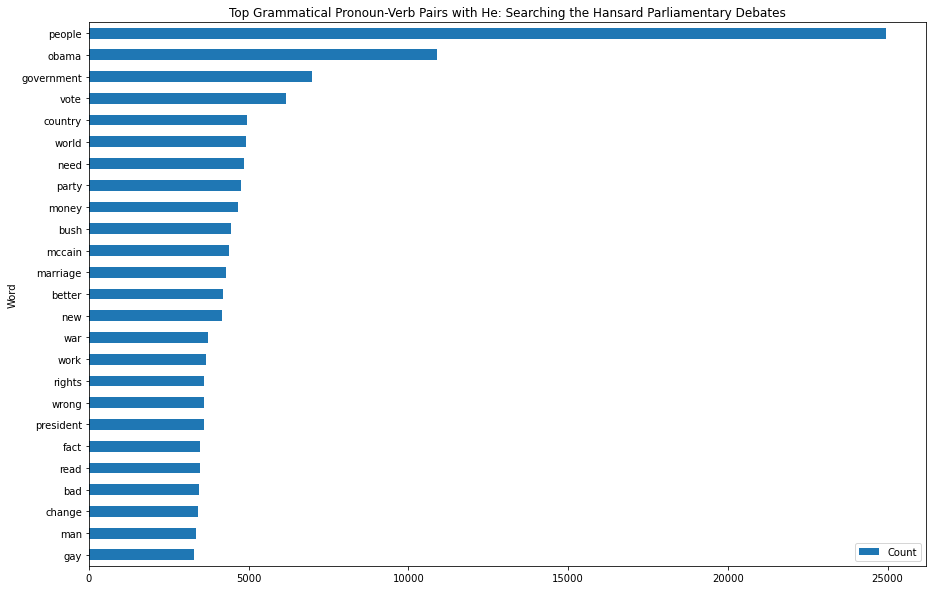

In [71]:
top_reddit_words.plot.barh(x = "Word", y = "Count", # visualize the count. 
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching the Hansard Parliamentary Debates")

## Working with Our Data: Implementing KeyWords in Context (KWIC)

For this last exercise we will find keywords in context (KWIC). You can think of KWIC's output like the lines of a concordance. 

To produce this output, we will split the text into n-grams where "n" stands for any number. For example, a text split into single words (like our data frame in the previous example) is split into 1-grams (also just called "tokens"). 3-grams split the text into units that are 3 words long. 5-grams split the text into units that are 5 words long. 

Our example will use reddit data from November 2008. We will create a dictionary too see keyword "Obama" in context.

First read in the data and do a little cleaning.

In [72]:
reddit_df = pd.read_csv('/scratch/group/oit_research_data/reddit/RC_2008-11.tsv', sep='\t') # read in the data 

reddit_df = reddit_df[reddit_df['body'] != '[deleted]'] # drop comments that have been deleted 

subreddit_filter = ('politics', 'worldnews', 'news') # specify the subreddits you want to use

reddit_df = reddit_df[reddit_df['subreddit'].isin(subreddit_filter)] # filter for the specified subreddits

reddit_df['body'] = reddit_df['body'].str.lower() # transform all words to lower case for consistency 

reddit_df['body'] = reddit_df['body'].str.replace('[^\w\s]','') # remove punctuation

reddit_df = reddit_df[~reddit_df['body'].isna()] # remove posts without commentary 

In [73]:
reddit_df

,Unnamed: 0,body,created_utc,downs,id,link_id,parent_id,subreddit,subreddit_id,ups
1,1,dude your phone is ringing dude dude your phon...,1225497628,0,c064gt4,t3_7ajhj,t1_c0648hy,news,t5_2qh3l,0
7,7,ask her to do it with her mouth full nudge kno...,1225497666,0,c064gta,t3_7ak8x,t1_c064dd3,worldnews,t5_2qh13,2
22,23,theres a difference between subtle tasteful ad...,1225497747,0,c064gtq,t3_7aklv,t1_c064c5m,politics,t5_2cneq,8
23,24,holy shit not only was my ad a floater mine wa...,1225497749,0,c064gtr,t3_7aklv,t1_c064b44,politics,t5_2cneq,2
29,30,do you know what they call proposition 8 in ho...,1225497763,0,c064gtx,t3_7ajk1,t3_7ajk1,politics,t5_2cneq,1
...,...,...,...,...,...,...,...,...,...,...
784047,792284,i think it was books like confessions of an ec...,1228089500,0,c06lhpj,t3_7gga6,t1_c06lfnb,worldnews,t5_2qh13,1
784056,792293,sorry i meant the video i was unaware there wa...,1228089540,0,c06lhps,t3_7gfkn,t1_c06lhp6,politics,t5_2cneq,1
784059,792296,hah thats your proof lets see the neocon bible...,1228089546,0,c06lhpv,t3_7gcxz,t1_c06lfr5,politics,t5_2cneq,1
784061,792298,yeah the darpa prize hasnt yielded any results,1228089554,0,c06lhpx,t3_7ghb5,t1_c06lfjz,politics,t5_2cneq,3


Now let's write a function that returns our keyword in context.

In [74]:
keyword = 'obama'

keyword_df = reddit_df[reddit_df['body'].str.contains(keyword)].copy() # search the text for the presence of our keyword 

def KWIC(body):
    n = 5 # specify the number of surrounding words to use before and after the keyword
    
    words = body.split() # split the words into tokens
    keyword_index = 0
    
    # The following for loop iterates through each word in the text. If our keyword is found, the for loop stores its index. 
    # But, why are we storing the index? As you might remember, the index is a numerical representation of the row's position.
    # It can also be thought of as a unique name the computer uses to identify a row. We can call the index to return JUST these rows.
    for index, word in enumerate(words): 
        if keyword in word: 
            keyword_index = index
            break
    
    before_keyword = words[max(0, keyword_index - n):keyword_index] # store the words that come before the keyword, up to our specified number 
    after_keyword = words[keyword_index:keyword_index + n] # store the words that come after the keyword, up to our specified number 
    return ' '.join(before_keyword + after_keyword) # return the keyword in its context

keyword_df['context'] = keyword_df['body'].apply(KWIC)

In [75]:
keyword_df[['context']]

,context
45,that obama voted and lobbied for
67,off without a hitch and obama wins nothing wil...
112,and remember why you elected obama because hes...
237,they are afraid of ners obama is the most set
285,state of hawaii is helping obama you show them...
...,...
783439,to invent some cynical crap obama isnt even in...
783540,effort not connected to the obama campaign or ...
783654,accounts were ever touched by obama just as ba...
783722,sitting president at this point obama holds du...


This data frame is a little difficult to look at, so I am going to export the contents to a file. 

In [77]:
keyword_df['context'].to_csv('KWIC_example_keyword_obama.csv', sep = ' ', index=False)

These are the first 18 lines from the file. 

> that obama voted and lobbied for

> off without a hitch and obama wins nothing will change

> and remember why you elected obama because hes the best

> they are afraid of ners obama is the most set

> state of hawaii is helping obama you show them the

> remaining 80 percent how are obamas policies different here we

> sounds pretty futile to me obama wont change anything but

> with his statement that an obama or mccain vote would

> would make shitty picks but obama will make equally shitty

> camped out there thats why obama has to keep his

> with the model being suggested obama just needs about 40

> i just saw an obama on mccain attack ad

> i get the impression that obama gets the problems he

> is president i dont expect obama to be any different

> ways dont you worry if obama falls down reddit will

> it is not senator obamas responsibility nor the democrats

> people to go away after obama wins and you possibly

> dear lord i remember michelle obama parading her kids around
